### Méthode 3:


Dans cette partie on essaiera de voir comment se comporte Bert en utilisant le finetuning sur une 3-classification.

Nous nous attendons des résultats aussi bons que ceux de la deuxième méthode où on utilisait les embedings avec un classifier

In [38]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from transformers import AlbertTokenizerFast, AlbertModel, DistilBertModel,DistilBertTokenizerFast
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizer,AutoTokenizer,BertForSequenceClassification


# specify GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Load Dataset

In [39]:
df = pd.read_csv("dataframe_names.csv")
df.head()

,Unnamed: 0,prenom,genre,fréquence
0,0,aaliyah,0,0.0
1,1,aapeli,1,0.0
2,2,aapo,1,0.0
3,3,aaren,2,0.0
4,4,aarne,1,0.0


In [40]:
df.dropna(inplace=True)

In [41]:
df.shape

(11626, 4)

In [42]:
# check class distribution
df['genre'].value_counts(normalize = True)

1    0.505591
0    0.456907
2    0.037502
Name: genre, dtype: float64

# Split train dataset into train, validation and test sets

In [43]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['prenom'], df['genre'], 
                                                                    random_state=0, 
                                                                    test_size=0.3, 
                                                                    stratify=df['genre'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=0, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [44]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


# Tokenization

In [47]:
np.array(train_text)

array(['cyan', 'babatunde', "mas'ud", ..., 'iolyn', 'yaroslav', 'þórir'],
      dtype=object)

<AxesSubplot:>

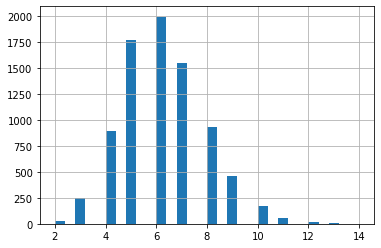

In [48]:
# get length of all the names in the train set
# this will help us to get the maximum length wich we'll set the padding to
seq_len = [len(str(i)) for i in np.array(train_text)]

pd.Series(seq_len).hist(bins = 30)

In [49]:
max_seq_len = 14

In [51]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [52]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [53]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [54]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [55]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,1024)
      
      self.fc2 = nn.Linear(1024,512)

      # dense layer 2 (Output layer)
      self.fc3 = nn.Linear(512,3)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      x=  self.fc3(x)
      # apply softmax activation
      x = self.softmax(x)

      return x

In [56]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [57]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 2e-4)

# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)


In [59]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [60]:
# function to train the model



def train():

  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [61]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [62]:
# set initial loss to infinite

best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')




 Epoch 1 / 10
  Batch    50  of    255.
  Batch   100  of    255.
  Batch   150  of    255.
  Batch   200  of    255.
  Batch   250  of    255.

Evaluating...
  Batch    50  of     55.

Training Loss: 1.076
Validation Loss: 1.011

 Epoch 2 / 10
  Batch    50  of    255.
  Batch   100  of    255.
  Batch   150  of    255.
  Batch   200  of    255.
  Batch   250  of    255.

Evaluating...
  Batch    50  of     55.

Training Loss: 0.971
Validation Loss: 0.866

 Epoch 3 / 10
  Batch    50  of    255.
  Batch   100  of    255.
  Batch   150  of    255.
  Batch   200  of    255.
  Batch   250  of    255.

Evaluating...
  Batch    50  of     55.

Training Loss: 0.940
Validation Loss: 0.898

 Epoch 4 / 10
  Batch    50  of    255.
  Batch   100  of    255.
  Batch   150  of    255.
  Batch   200  of    255.
  Batch   250  of    255.

Evaluating...
  Batch    50  of     55.

Training Loss: 0.922
Validation Loss: 0.879

 Epoch 5 / 10
  Batch    50  of    255.
  Batch   100  of    255.
  Batch  

Remarque:

l'erreur de validation diminue au fil des epochs, on pourrait éventuellement atteindre de meilleurs résultats si on augmente le nombre d'epochs.

D'autres hyperparametres peuvent intervenir dans la qualité de nos résultats comme le learning rate, la complexité des layers qu'on rajoute au dessus du model pre-entrainé , la taille des bachs etc

Cela prend neanmoins beacoup de temps, on se contentera du meilleur model sur les 10 epochs si dessus.

# Load Saved Model

In [71]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [77]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.cpu().numpy()

In [78]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82       797
           1       0.83      0.84      0.83       882
           2       0.10      0.14      0.12        65

    accuracy                           0.80      1744
   macro avg       0.59      0.59      0.59      1744
weighted avg       0.81      0.80      0.80      1744



In [74]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1,2
row_0,,,
0,640,117,40
1,100,741,41
2,20,36,9


Selon les résultats ci-dessus, on a une meilleur performence avec la deuxième méthode de classification et notement en ce qui concerne la classe de noms épicenes.
Cela pourrait être expliqué par le peu de prénoms de cette catégorie dans le dataset, et donc dans la phase d'entrainement.

On peut également dire que Bert atteint son potentiel maximal quand une notion de contexte est existante, ce n'est pas le cas ici.